https://www.kaggle.com/c/quora-insincere-questions-classification/data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
# path = Path('/Users/nikhil/workspace/fastaiv1/my_data/quora')

In [3]:
path = Path(Config.get_key('data_path')).expanduser()/'quora'
os.makedirs(path, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/quora')

In [5]:
# ! /opt/anaconda3/bin/kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p {path}
# ! /opt/anaconda3/bin/kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p {path}
# ! unzip {path}/train.csv.zip -d {path}
# ! unzip {path}/test.csv.zip -d {path}
# ! chmod 775 -R {path}

In [4]:
df = pd.read_csv(path/'train.csv')

In [5]:
def label(row):
    return 'positive' if row.target else 'negative'

df['label'] = df.apply(lambda row: label(row), axis=1)
df = df.rename(columns = {"question_text": "text"})
df = df.drop(['qid', 'target'], axis=1)

In [6]:
import random
# assign true value with probability of 0.8
df['is_valid'] = df.apply(lambda x:0.8 > random.random(), axis=1)

#len(df) == len(df.qid.unique()) #1306122

In [7]:
len_df = int(len(df)*.8)
train_df, valid_df = df[:len_df], df[len_df:]
# for cpu local
train_df = train_df[:int(len(train_df)*.01)]
# valid_df = valid_df[:int(len(valid_df)*.01)]
train_df.head()

,text,label,is_valid
0,How did Quebec nationalists see their province...,negative,True
1,"Do you have an adopted dog, how would you enco...",negative,True
2,Why does velocity affect time? Does velocity a...,negative,True
3,How did Otto von Guericke used the Magdeburg h...,negative,True
4,Can I convert montra helicon D to a mountain b...,negative,True


In [8]:
train_df.to_csv(path/'texts.csv', index=False, columns=['label', 'text', 'is_valid'])
# valid_df.to_csv(path/'valid.csv', index=False, columns=['label', 'text', 'is_valid'])

In [18]:
# data_lm = TextDataBunch.from_csv(path, train='texts', valid='valid')
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')

In [19]:
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103)

In [20]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


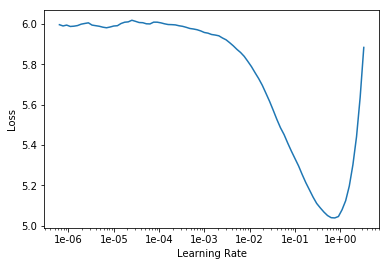

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), wd=0.03)

Total time: 00:12
epoch  train_loss  valid_loss  accuracy
1      4.405884    3.426650    0.394440  (00:12)



In [23]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head')

In [25]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7), wd=0.03, pct_start=0.25)

Total time: 02:41
epoch  train_loss  valid_loss  accuracy
1      3.452391    3.041799    0.450183  (00:15)
2      3.225230    2.932465    0.461694  (00:16)
3      3.093610    2.858890    0.468098  (00:15)
4      2.984475    2.854669    0.466126  (00:16)
5      2.873828    2.823801    0.471288  (00:16)
6      2.781103    2.802531    0.473218  (00:16)
7      2.704645    2.814418    0.471709  (00:16)
8      2.636070    2.808258    0.473054  (00:16)
9      2.587451    2.818980    0.471915  (00:16)
10     2.561047    2.813143    0.472025  (00:15)



In [26]:
learn.save('fine_tuned')

In [27]:
learn.save_encoder('fine_tuned_enc')

In [28]:
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', bs=50)

In [29]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [30]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


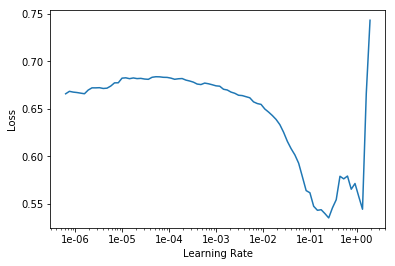

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 00:16
epoch  train_loss  valid_loss  accuracy
1      0.187442    0.163065    0.939234  (00:16)



In [ ]:
learn.save('first')
learn.load('first')

In [35]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/2.6,1e-2), moms=(0.8,0.7), pct_start=0.1)

Total time: 00:17
epoch  train_loss  valid_loss  accuracy
1      0.178828    0.150270    0.946890  (00:17)



In [ ]:
learn.save('second')
learn.load('second')

In [37]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**2),5e-3), moms=(0.8,0.7), pct_start=0.1)

Total time: 00:28
epoch  train_loss  valid_loss  accuracy
1      0.176829    0.158846    0.946890  (00:28)



In [ ]:
learn.save('third')
learn.load('third')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), pct_start=0.1)

epoch,train_loss,valid_loss,accuracy
